---------------------------

Data preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pystan
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the data
df_original = pd.read_csv("data.csv")
df_original = df_original.rename(columns=df_original.iloc[0])
df = df_original.drop(df_original.index[0])

# Convert the data types
df["Year"] = df["Year"].astype(int)
df["Male"] = df["Male"].astype(float)
df["Female"] = df["Male"].astype(float)
df["Both sexes"] = df["Both sexes"].astype(float)

df.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
Year,28.0,2011.0,7.2,2000.0,2007.5,2012.5,2016.0,2019.0
Both sexes,28.0,70.6,6.2,52.7,67.4,71.8,75.6,78.2
Male,28.0,68.2,5.7,51.1,65.6,69.2,72.5,75.1
Female,28.0,68.2,5.7,51.1,65.6,69.2,72.5,75.1


In [ ]:
df

,WHO region,Year,Both sexes,Male,Female
1,Global,2019,73.3,70.8,70.8
2,Global,2015,72.3,69.8,69.8
3,Global,2010,70.5,68.0,68.0
4,Global,2000,66.8,64.4,64.4
5,Africa,2019,64.5,62.4,62.4
6,Africa,2015,62.6,60.5,60.5
7,Africa,2010,59.5,57.7,57.7
8,Africa,2000,52.7,51.1,51.1
9,Americas,2019,77.2,74.5,74.5
10,Americas,2015,76.8,74.1,74.1


## The pooled model

In [ ]:
the_pooled_model = """
    data {
        int<lower=0> N;
        vector[N] x;
        vector[N] y;
        real xpred;
        real tau;  // prior std for beta
    }
    parameters {
        real alpha;              // intercept
        real beta;               // slopes of vars
        real<lower=0> sigma;     // total error
    }
    model{
        beta ~ normal(0, tau); // Beta parameter prior-distribution
        alpha ~ normal(-600, 100);
        sigma ~ normal(0, 10); // error
        y ~ normal(alpha + beta*x, sigma);
    }
    generated quantities {
        vector[N] yrep;
        real ypred;

        for (n in 1:N) {
            yrep[n] = normal_rng(alpha + beta*x[n], sigma);
        }

        // predict the life expectancy for the year 2020
        ypred = normal_rng(alpha + beta*xpred, sigma);
    }

"""

In [ ]:
# Input the data properly
pooled_data_dict = {}
pooled_data_dict["N"] = len(df["Year"])
pooled_data_dict["x"] = np.asarray(df["Year"].values, dtype=int)
pooled_data_dict["y"] = np.asarray(df["Both sexes"].values, dtype=float)
pooled_data_dict["xpred"] = 2020
pooled_data_dict["tau"] = 16

In [ ]:
# Run the stan model
pooled_fit = pystan.stan(
    model_code = the_pooled_model,
    data = pooled_data_dict,
    iter = 2000,
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a02badcec94ac6be0a6ec418d3cbbb22 NOW.


In [ ]:
print(pooled_fit.stansummary(pars=['sigma', 'alpha', 'beta', 'ypred']))

Inference for Stan model: anon_model_a02badcec94ac6be0a6ec418d3cbbb22.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   5.94    0.02   0.82   4.63   5.35   5.85   6.44   7.79   1521    1.0
alpha -601.6    2.94  96.89 -789.5 -667.5 -601.3 -537.6 -408.8   1087    1.0
beta    0.33  1.5e-3   0.05   0.24    0.3   0.33   0.37   0.43   1088    1.0
ypred  73.44     0.1   6.16  61.17  69.36   73.5  77.35  85.46   4146    1.0

Samples were drawn using NUTS at Thu Dec  2 09:52:07 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


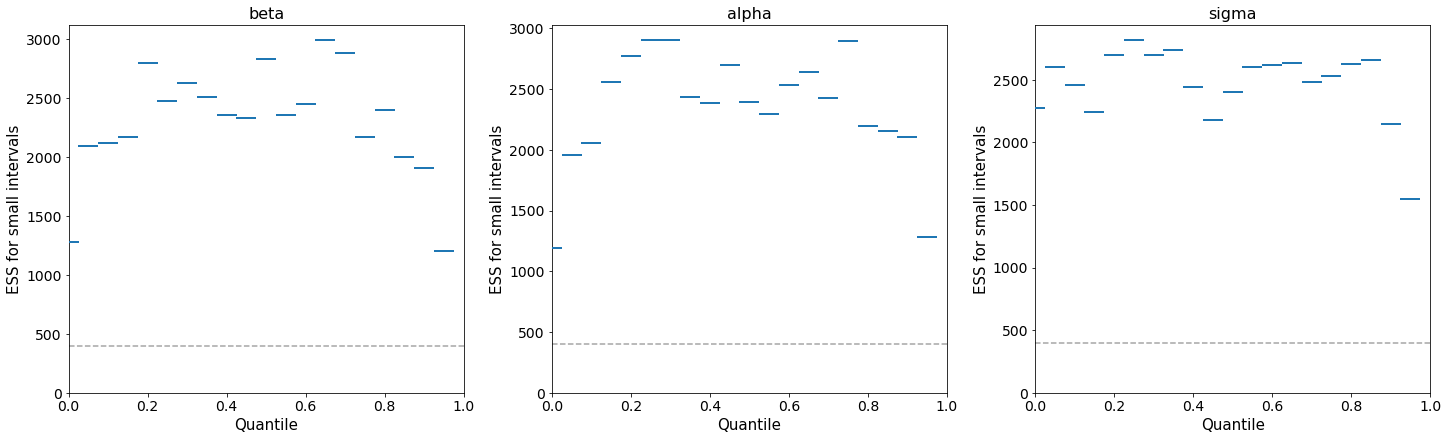

In [ ]:
_ = az.plot_ess(
    pooled_fit, var_names=["beta", "alpha", "sigma"],
    kind="local", marker="_", ms=20, mew=2, figsize=(20, 6)
)

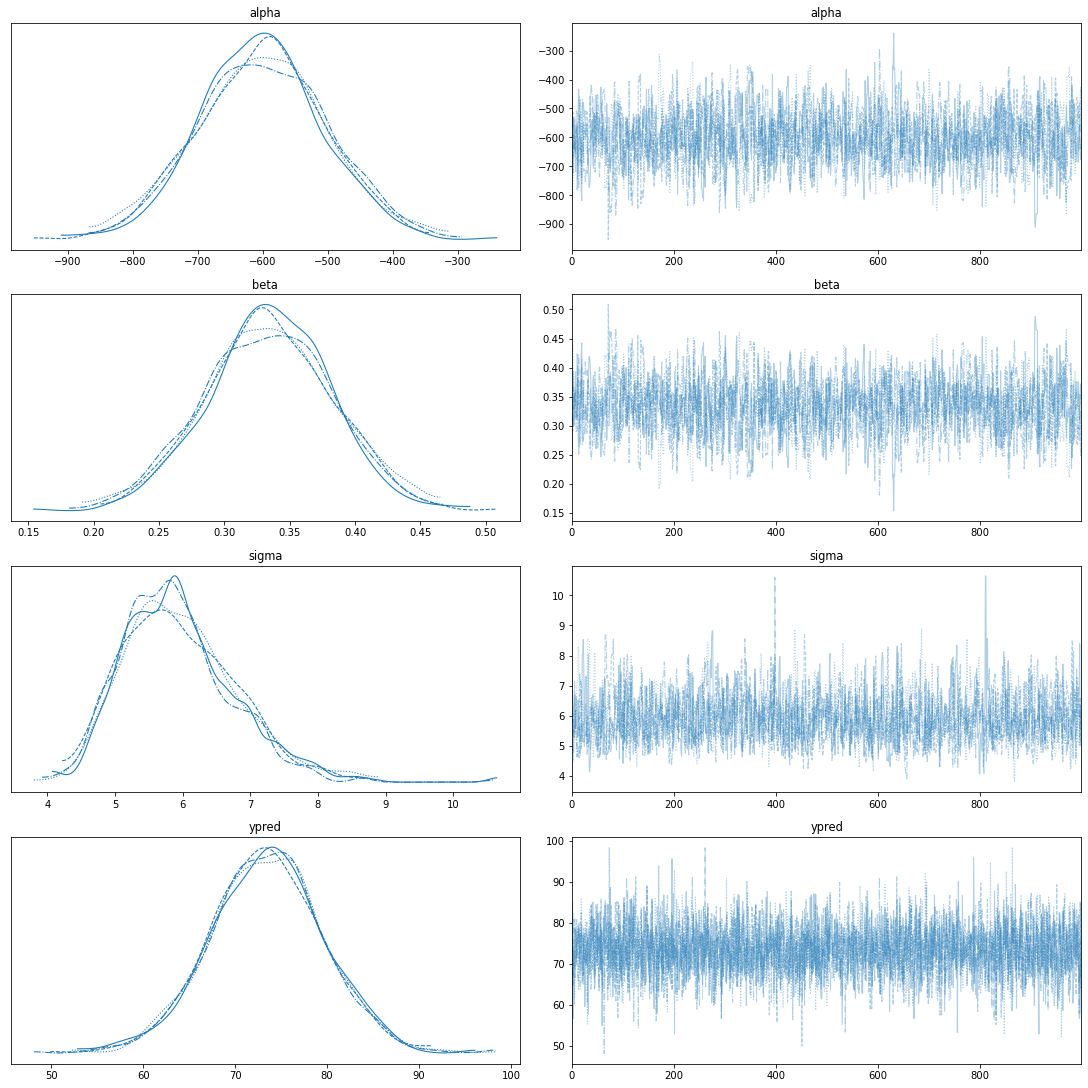

In [ ]:
_ = az.plot_trace(pooled_fit, var_names = ["alpha", "beta", "sigma", "ypred"], figsize=(15, 15))

In [ ]:
p = pooled_fit.to_dataframe(diagnostics=True)
print('quantiles treedepth for draws:\n', p['treedepth__'].quantile([0, 0.25, 0.5, 0.75, 1]))
print('divergent transitions: ', any(p['divergent__']))

quantiles treedepth for draws:
 0.00    1.0
0.25    7.0
0.50    8.0
0.75    8.0
1.00    9.0
Name: treedepth__, dtype: float64
divergent transitions:  False


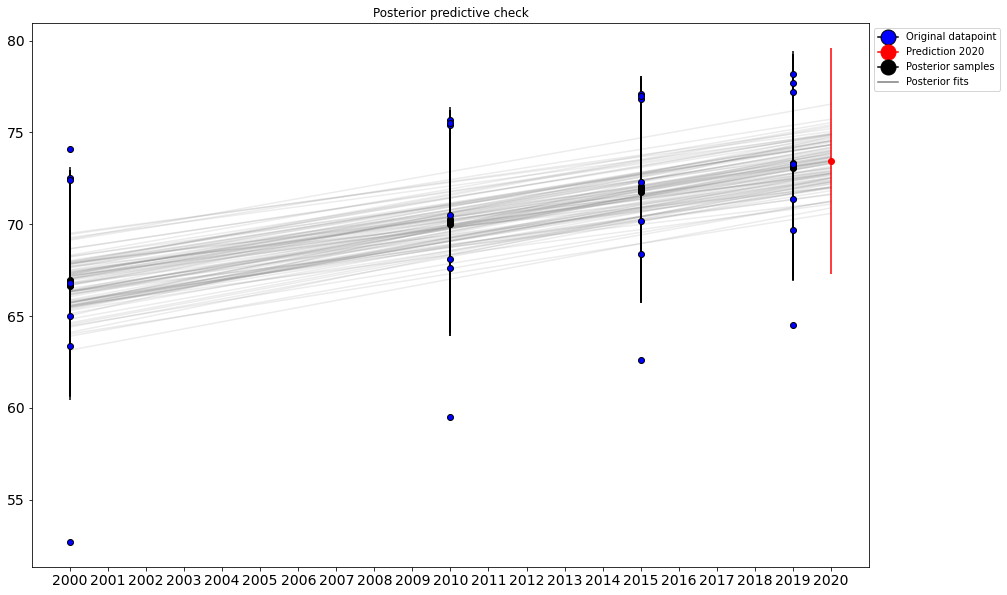

In [ ]:
# Plot posterior predictive checks
b = pooled_fit.to_dataframe()
plt.figure(figsize=(15,10))
vuosi = np.linspace(2000, 2020)
y = np.mean(pooled_fit["beta"]) * vuosi + np.mean(pooled_fit["alpha"])

for i in range(100):
    y = pooled_fit["beta"][i] * vuosi + pooled_fit["alpha"][i]
    _ = plt.plot(vuosi, y, zorder=i, color='gray', alpha=0.15)

for j in reversed(range(1, 29)):
    yrep = pooled_fit[f'yrep[{j}]']
    _ = plt.errorbar(
        x = pooled_data_dict["x"][j-1],
        y = np.mean(yrep),
        yerr=np.std(yrep),
        fmt='--o', zorder=i+j,
        ecolor='black', capthick=2,
        color='black',
    )

ypred = pooled_fit['ypred']
_ = plt.errorbar(
    x = 2020,
    y = np.mean(ypred),
    yerr=np.std(ypred),
    fmt='--o', zorder=i+j+100,
    ecolor='red', capthick=2,
    color='red',
)

_ = plt.scatter(
    pooled_data_dict["x"], pooled_data_dict["y"],
    zorder=j+i+100, edgecolors='black', color='b'
)
_ = plt.title("Posterior predictive check")

custom_legends = [
    Line2D(
        [0], [0], marker='o', color='black',markerfacecolor='b',
        label='Original datapoint', markersize=15
    ),
    Line2D(
        [0], [0], marker='o', color='red',
        label='Prediction 2020', markersize=15
    ),
    Line2D(
        [0], [0], marker='o', color='black',
        label='Posterior samples', markersize=15
    ),
    Line2D(
        [0], [0], color='gray',
        label='Posterior fits', markersize=15
    ),

]

_ = plt.legend(handles=custom_legends, bbox_to_anchor=(1, 1))
_ = plt.xticks(np.arange(2000, 2021), fontsize=14)
_ = plt.yticks(fontsize=14)

In [ ]:
az.r2_score(pooled_data_dict["y"], np.mean(pooled_fit["yrep"], axis=0))

r2        0.15773
r2_std    0.00000
dtype: float64

In [ ]:
# Run pooled stan model with different beta priors
# uniform, normal(0, sigma=tau=16), normal(0, sigma=tau=26)
pooled_fit_uniform = pystan.stan(
    model_code = the_pooled_model,
    data = pooled_data_dict,
    iter = 2000,
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a02badcec94ac6be0a6ec418d3cbbb22 NOW.


In [ ]:
pooled_fit_tau26 = pystan.stan(
    model_code = the_pooled_model,
    data = pooled_data_dict,
    iter = 2000,
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a02badcec94ac6be0a6ec418d3cbbb22 NOW.


INFO:numba.core.transforms:finding looplift candidates


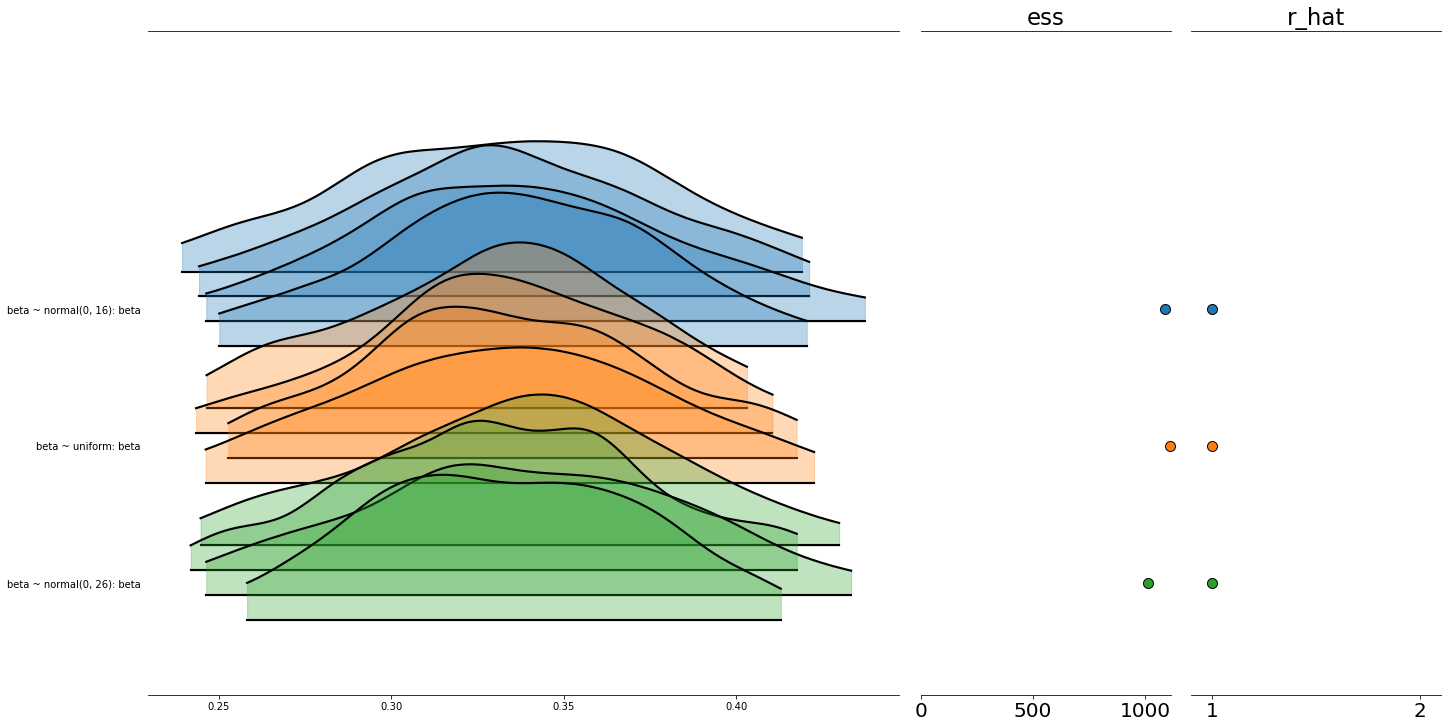

In [ ]:
_ = az.plot_forest(
    [pooled_fit, pooled_fit_uniform, pooled_fit_tau26],
    model_names=["beta ~ normal(0, 16)", "beta ~ uniform", "beta ~ normal(0, 26)",], var_names=["beta"], markersize=10,
    kind='ridgeplot', ridgeplot_overlap=3, ridgeplot_alpha=0.3, r_hat=True, ess=True, figsize=(20, 10), textsize=20
)

plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.savefig('sensitivity_pooled.png')

## The hierarchical model

In [ ]:
the_hier_model = """
    data {
        int<lower=0> N;
        vector[N] x;
        vector[N] y;
        int<lower=0> n_region;
        int<lower=1, upper=n_region> region_enc[N];
        real xpred;
        real tau;
    }
    parameters {
        real<lower=0> sigma;
        real global_mu_alpha;
        real<lower=0> global_sd_alpha;
        real global_mu_beta;
        real<lower=0> global_sd_beta;

        vector[n_region] alpha_region;
        vector[n_region] beta_region;
    }

    model {

        global_mu_alpha ~ normal(0, 10);
        global_sd_alpha ~ cauchy(0, 10);

        global_mu_beta ~ normal(0, tau);
        global_sd_beta ~ scaled_inv_chi_square(4, 1);

        for (c in 1:n_region) {
              alpha_region[c]~ normal(global_mu_alpha, global_sd_alpha);
              beta_region[c] ~ normal(global_mu_beta, global_sd_beta);
        }

        sigma ~ normal(0, 10);  // prior for error
        y ~ normal(alpha_region[region_enc] + beta_region[region_enc].*x, sigma);
    }
    generated quantities {
        matrix[N, n_region] yrep;
        vector[n_region] ypred;
        for (k in 1:n_region) {
            for(n in 1:N) {
                yrep[n, k] = normal_rng(alpha_region[k] + beta_region[k]*x[n], sigma);
            }
            ypred[k] = normal_rng(alpha_region[k] + beta_region[k]*xpred, sigma);
        }

    }

"""

In [ ]:
# Input the data properly
hier_data_dict = {}
hier_data_dict["N"] = 28
hier_data_dict["x"] = np.asarray(df["Year"].values, dtype=int)
hier_data_dict["y"] = np.asarray(df["Both sexes"].values, dtype=float)
hier_data_dict["n_region"] = 7
hier_data_dict["xpred"] = 2020
hier_data_dict["tau"] = 16

# Region encoding
region = df["WHO region"]
region = region.replace("Global", 7)
region = region.replace("Africa", 1)
region = region.replace("Americas", 2)
region = region.replace("South-East Asia", 3)
region = region.replace("Europe", 4)
region = region.replace("Eastern Mediterranean", 5)
region = region.replace("Western Pacific", 6)
hier_data_dict["region_enc"] = region

In [ ]:
# Run the stan model
hier_fit = pystan.stan(
    model_code = the_hier_model,
    data = hier_data_dict,
    iter = 4000,
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0579b78437fdbb935fc466821f0aa85d NOW.


In [ ]:
print(hier_fit.stansummary(pars=['sigma', 'alpha_region', 'beta_region']))

Inference for Stan model: anon_model_0579b78437fdbb935fc466821f0aa85d.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma             0.31  1.2e-3   0.07   0.21   0.26    0.3   0.34   0.47   2898    1.0
alpha_region[1]  -1196    0.54  44.27  -1283  -1225  -1197  -1169  -1105   6777    1.0
alpha_region[2] -266.3    0.57  43.83 -353.1 -294.1 -266.2 -238.5 -179.7   5828    1.0
alpha_region[3] -787.8    0.51  42.87 -870.2 -815.8 -788.6 -760.8 -701.2   7115    1.0
alpha_region[4] -526.6    0.54  44.32 -613.6 -555.5 -526.5 -498.8 -437.1   6750    1.0
alpha_region[5] -415.4    0.53  44.17 -502.7 -443.5 -416.1 -387.6 -325.7   6833    1.0
alpha_region[6] -497.7    0.55  44.47 -585.2 -526.6 -497.4 -469.8 -409.7   6625    1.0
alpha_region[7] -626.1     0.5  43.35 -711.4 -654.2 -626.3 -598.9 -539.7   7560    1.0
beta_region[1]    0.62  2.7e

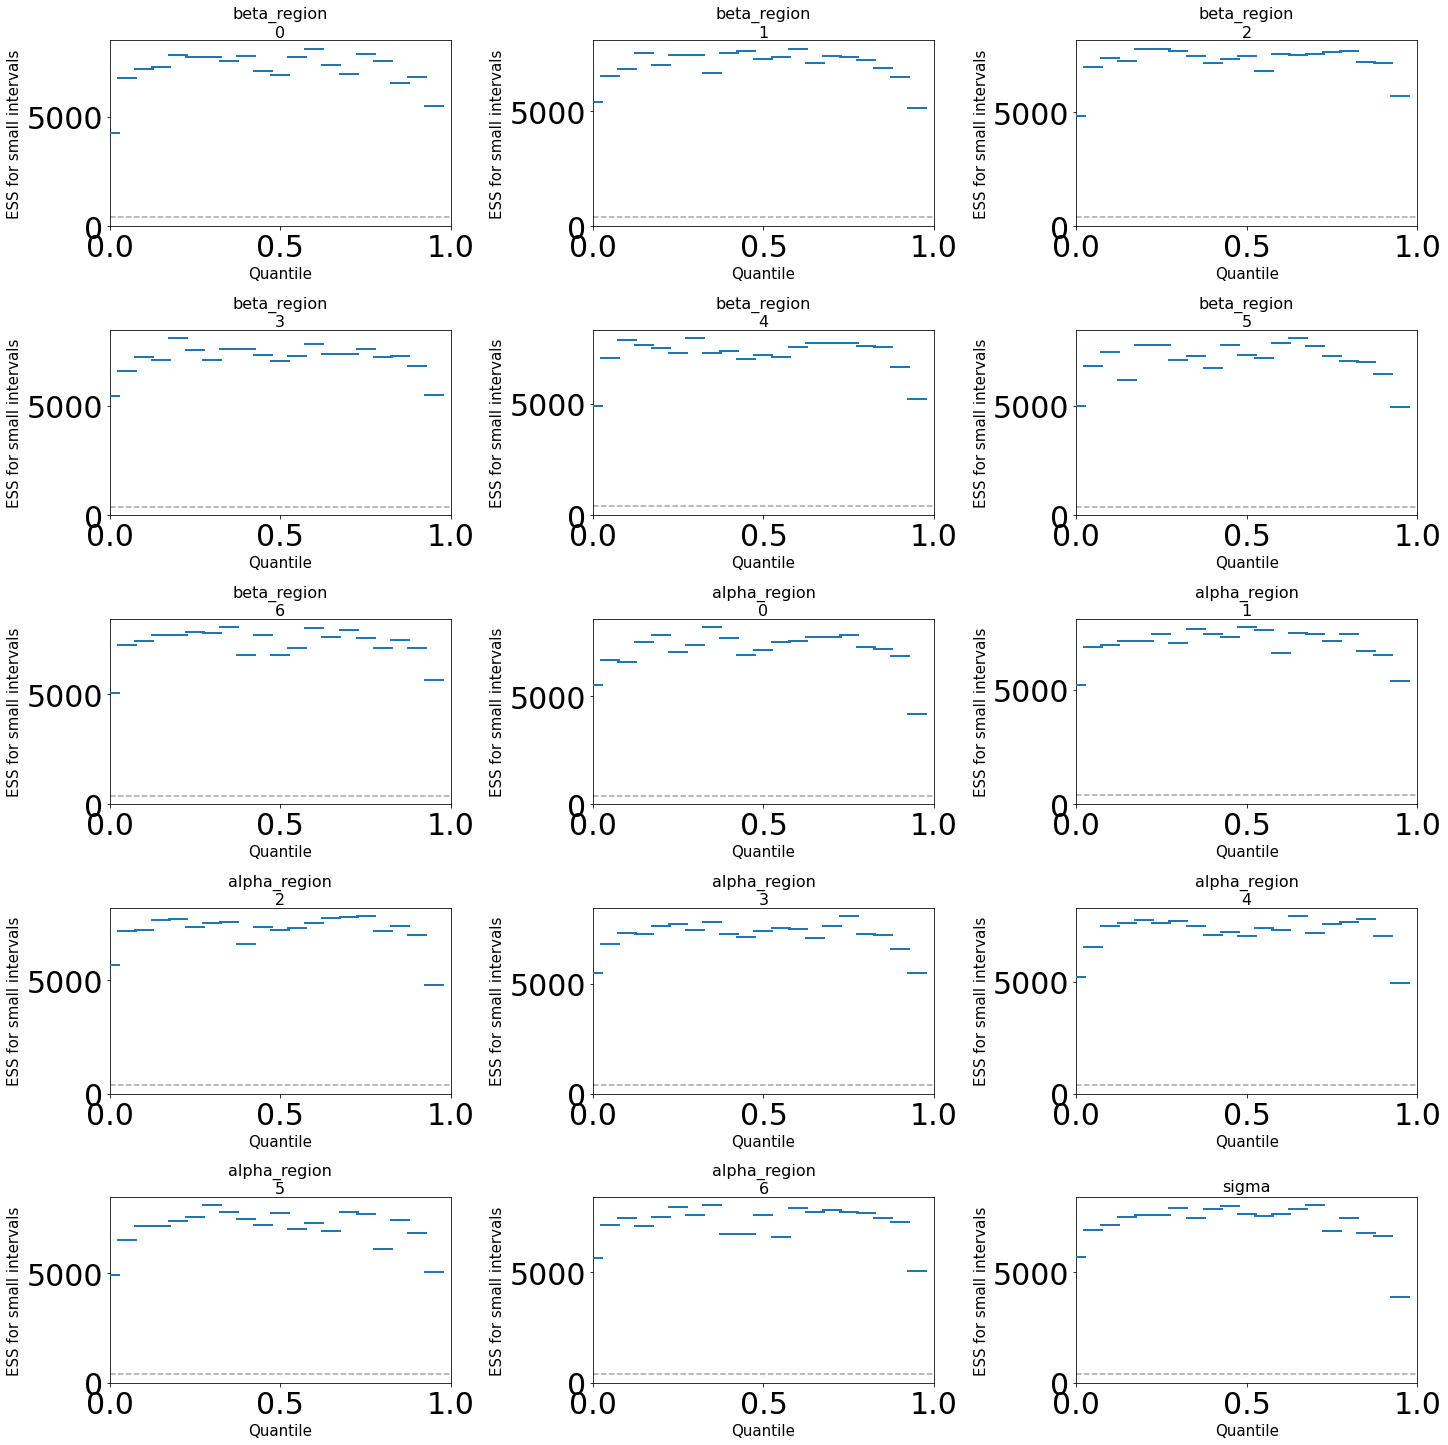

In [ ]:
_ = az.plot_ess(
    hier_fit, var_names=["beta_region", "alpha_region", "sigma"],
    kind="local", marker="_", ms=20, mew=2, figsize=(20, 20)
)

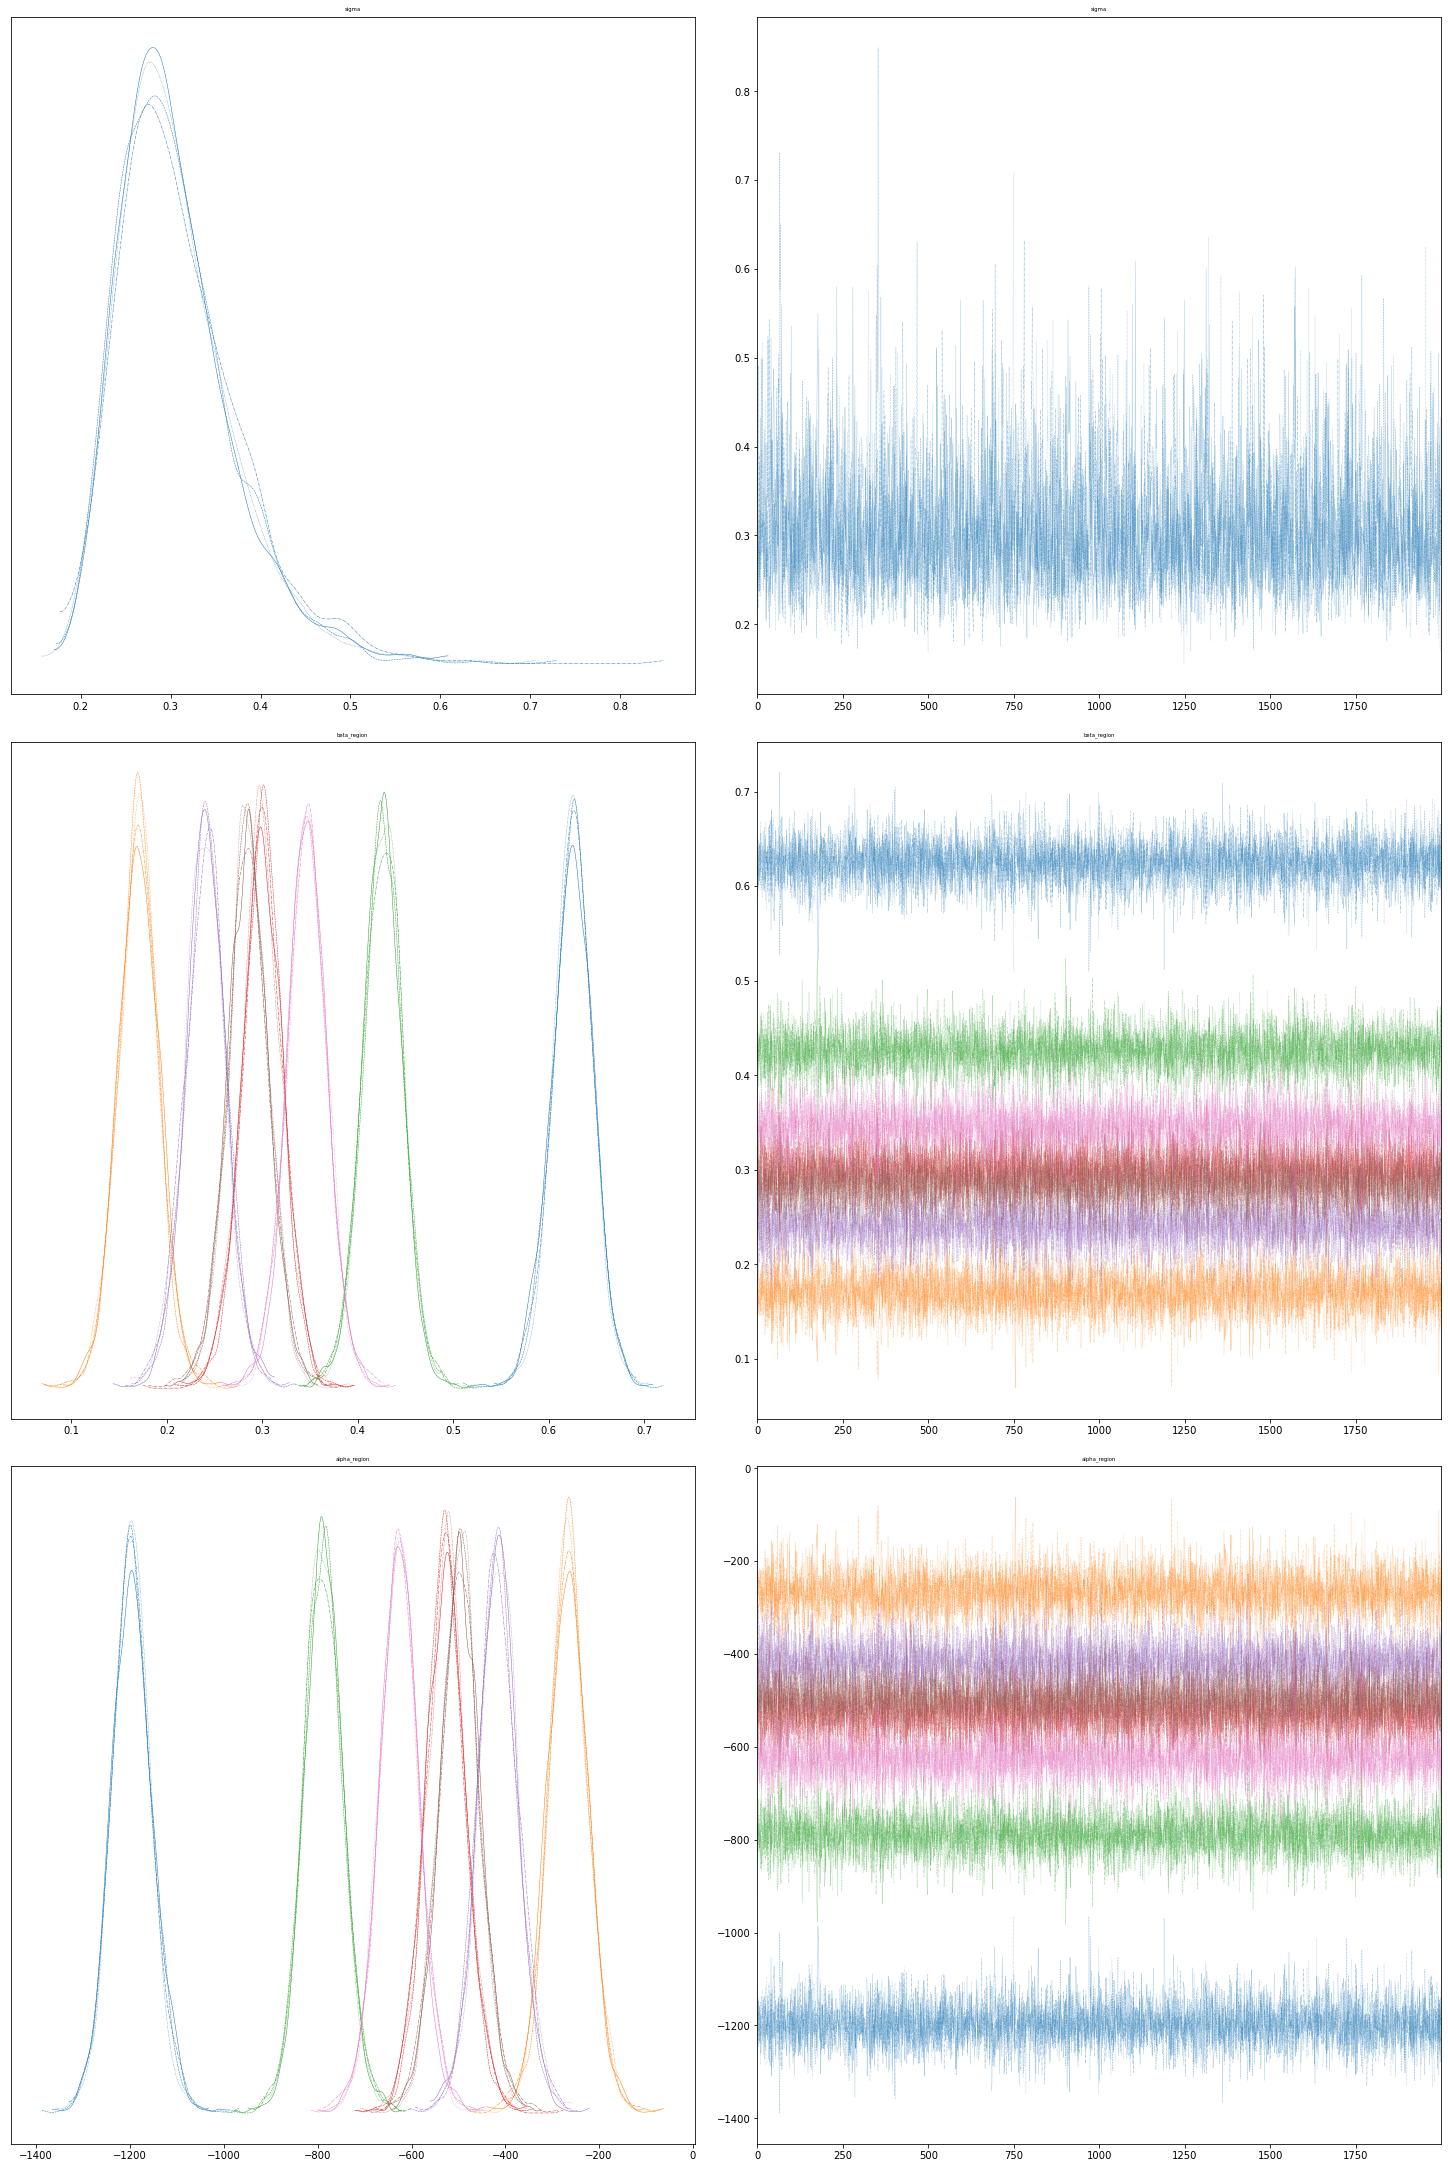

In [ ]:
_ = az.plot_trace(hier_fit, var_names = ["sigma", "beta_region", "alpha_region"], figsize=(20, 30))

In [ ]:
h = hier_fit.to_dataframe(diagnostics=True)
print('max treedepth for draws: ', h['treedepth__'].max())
print('min treedepth for draws: ', h['treedepth__'].min())
print('mean treedepth for draws: ', h['treedepth__'].mean())
print('divergent transitions: ', any(h['divergent__']))

max treedepth for draws:  14
min treedepth for draws:  3
mean treedepth for draws:  11.387125
divergent transitions:  False


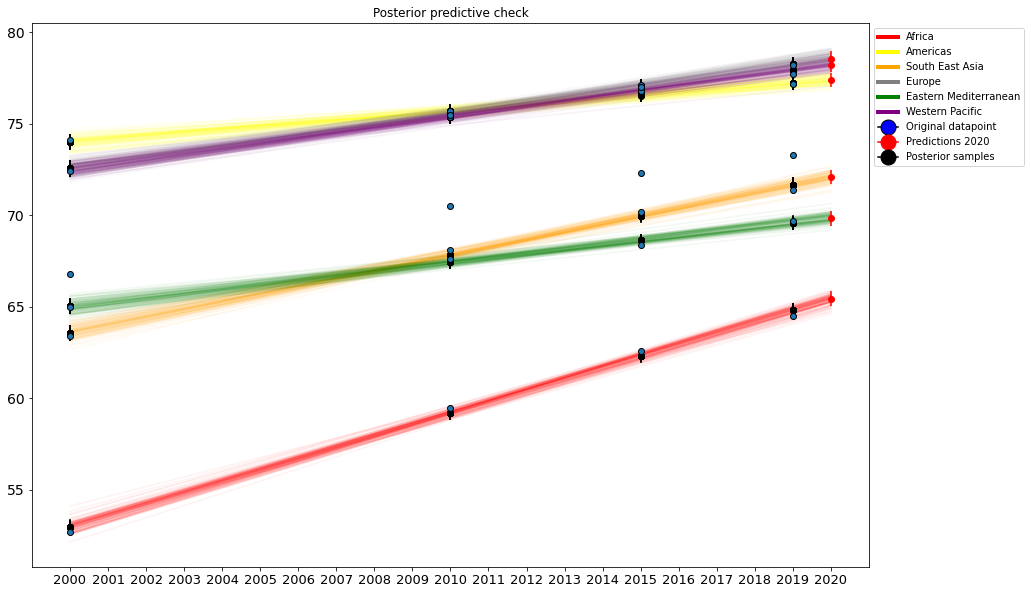

In [ ]:
plt.figure(figsize=(15,10))
vuosi = np.linspace(2000, 2020)

colors = ['red', 'yellow', 'orange', 'gray', 'green', 'purple', 'pink']
for x in range(1, 7):
    print()
    for i in range(100):
        y = hier_fit["beta_region"][:, x-1][i] * vuosi + hier_fit["alpha_region"][:, x-1][i]
        _ = plt.plot(vuosi, y, color=colors[x-1], alpha=0.05)

for x in range(1, 7):
    for j in reversed(range(1, 29)):
        yrep = hier_fit['yrep[{},{}]'.format(j, x)]
        _ = plt.errorbar(
            x = hier_data_dict["x"][j-1],
            y = np.mean(yrep),
            yerr=np.std(yrep),
            fmt='--o', zorder=i+j,
            ecolor='black', capthick=2,
            color='black',
        )

for k in range(1, 7):
    ypred = hier_fit['ypred[{}]'.format(k)]
    _ = plt.errorbar(
        x = 2020,
        y = np.mean(ypred),
        yerr=np.std(ypred),
        fmt='--o', zorder=i+j+100,
        ecolor='red', capthick=2,
        color='red',
    )

_ = plt.scatter(hier_data_dict["x"], hier_data_dict["y"], zorder=j+i+100, edgecolors='black')
_ = plt.title("Posterior predictive check")
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


custom_lines = [
    Line2D([0], [0], color='red', lw=4, label='Africa'),
    Line2D([0], [0], color='yellow', lw=4, label='Americas'),
    Line2D([0], [0], color='orange', lw=4, label='South East Asia'),
    Line2D([0], [0], color='gray', lw=4, label='Europe'),
    Line2D([0], [0], color='green', lw=4, label='Eastern Mediterranean'),
    Line2D([0], [0], color='purple', lw=4, label='Western Pacific'),
    Line2D([0], [0], marker='o', color='black', label='Original datapoint', markerfacecolor='b', markersize=15),
    Line2D([0], [0], marker='o', color='red', label='Predictions 2020', markersize=15),
    Line2D([0], [0], marker='o', color='black', label='Posterior samples', markersize=15),

]

_ = plt.legend(handles=custom_lines, bbox_to_anchor=(1, 1))
_ = plt.xticks(np.arange(2000, 2021), fontsize=13)
_ = plt.yticks(fontsize=14)

In [ ]:
# R2 values
ytrue_africa = np.asarray(df[df["WHO region"] == "Africa"]["Both sexes"], dtype=float)
ytrue_americas = np.asarray(df[df["WHO region"] == "Americas"]["Both sexes"], dtype=float)
ytrue_easternmed = np.asarray(df[df["WHO region"] == "Eastern Mediterranean"]["Both sexes"], dtype=float)
ytrue_europe = np.asarray(df[df["WHO region"] == "Europe"]["Both sexes"], dtype=float)
ytrue_sea = np.asarray(df[df["WHO region"] == "South-East Asia"]["Both sexes"], dtype=float)
ytrue_wp = np.asarray(df[df["WHO region"] == "Western Pacific"]["Both sexes"], dtype=float)

In [ ]:
yrep_matrix = np.mean(hier_fit["yrep"], axis = 0)

In [ ]:
np.mean(yrep_matrix[:,0].reshape(7,4), axis=0)

array([64.82520785, 62.32658182, 59.20153119, 52.95574838])

In [ ]:
yrep_africa = np.mean(yrep_matrix[:,0].reshape(7,4), axis=0)
yrep_americas = np.mean(yrep_matrix[:,1].reshape(7,4), axis=0)
yrep_easternmed = np.mean(yrep_matrix[:,2].reshape(7,4), axis=0)
yrep_europe = np.mean(yrep_matrix[:,3].reshape(7,4), axis=0)
yrep_sea = np.mean(yrep_matrix[:,4].reshape(7,4), axis=0)
yrep_wp = np.mean(yrep_matrix[:,5].reshape(7,4), axis=0)

In [ ]:
r2_africa = az.r2_score(ytrue_africa, yrep_africa)
r2_americas = az.r2_score(ytrue_americas, yrep_americas)
r2_easternmed = az.r2_score(ytrue_easternmed, yrep_easternmed)
r2_europe = az.r2_score(ytrue_europe, yrep_europe)
r2_sea = az.r2_score(ytrue_sea, yrep_sea)
r2_wp = az.r2_score(ytrue_wp, yrep_wp)
r2_dict = {
    'Africa':r2_africa,
    'Americas':r2_americas,
    'Eastern Mediterranean':r2_easternmed,
    'Europe':r2_europe,
    'South East Asia':r2_sea,
    'Western Pacific': r2_wp
}

In [ ]:
pd.DataFrame(r2_dict)

,Africa,Americas,Eastern Mediterranean,Europe,South East Asia,Western Pacific
r2,0.995769,0.972825,0.839114,0.998454,0.613368,0.992287
r2_std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
hier_fit_uniform = pystan.stan(
    model_code = the_hier_model,
    data = hier_data_dict,
    iter = 4000,
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0579b78437fdbb935fc466821f0aa85d NOW.


In [ ]:
hier_fit_tau26 = pystan.stan(
    model_code = the_hier_model,
    data = hier_data_dict,
    iter = 4000,
    chains = 4,
    control=dict(
        max_treedepth=15
    )
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0579b78437fdbb935fc466821f0aa85d NOW.


INFO:numba.core.transforms:finding looplift candidates


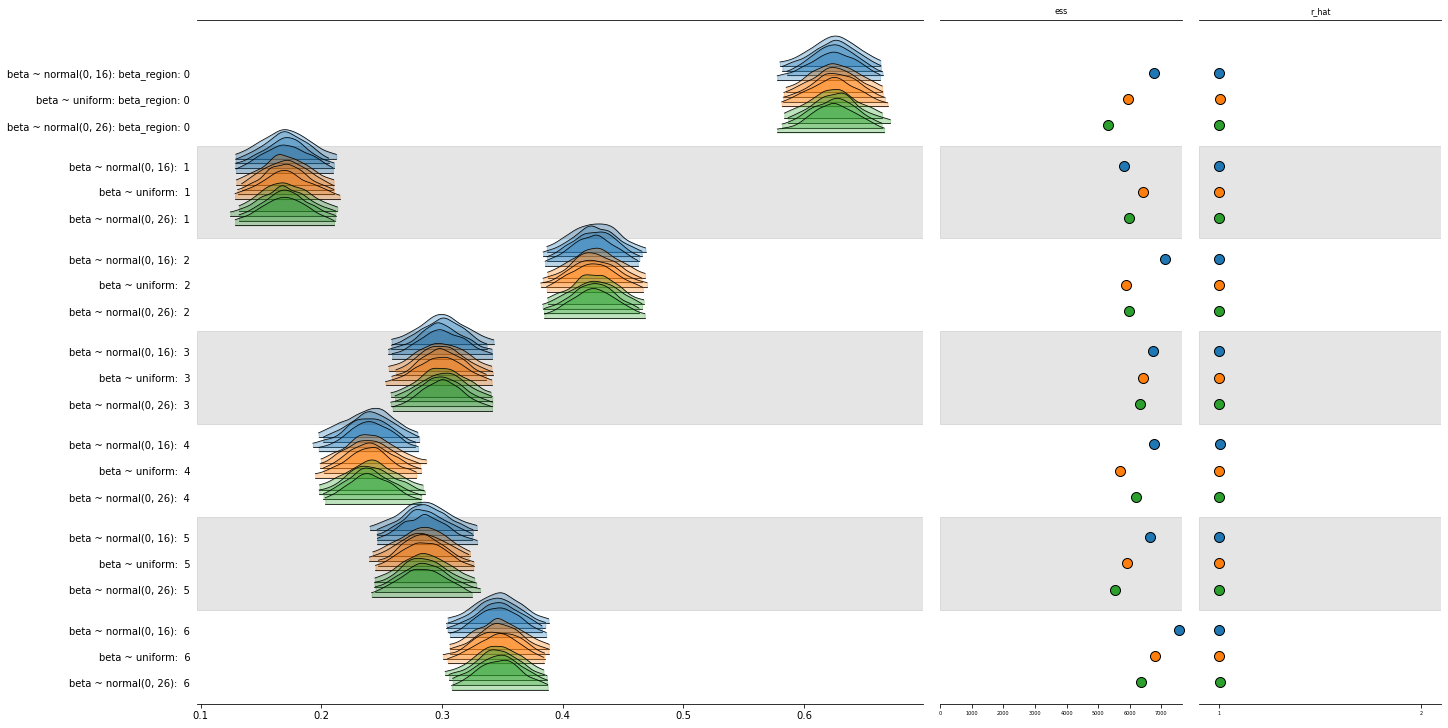

In [ ]:
_ = az.plot_forest(
    [hier_fit, hier_fit_uniform, hier_fit_tau26],
    model_names=["beta ~ normal(0, 16)", "beta ~ uniform", "beta ~ normal(0, 26)",], var_names=["beta_region"], markersize=10,
    kind='ridgeplot', ridgeplot_overlap=3, ridgeplot_alpha=0.3, r_hat=True, ess=True, figsize=(20, 10), textsize=5
)

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.savefig("sensitivity_hier.png")